In [1]:
import os
import time
import ray
from ray.tune import registry
import copy
import pandas as pd
import numpy as np
from pyfolio import timeseries
import matplotlib.pyplot as plt
import json
from ray.rllib.agents.ppo import PPOTrainer

from envs.training_env import LearningCryptoEnv # for One-way strategy
from config import ppo_config # for One-way strategy

# from envs.training_env_long import LearningCryptoEnv # for Long only strategy
# from config_long import ppo_config # for Long only strategy

/home/xkaple00/anaconda3/envs/sane_ai_4/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
/home/xkaple00/anaconda3/envs/sane_ai_4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_daily_return(df, value_col_name="account_value"):
    df = copy.deepcopy(df)
    df["daily_return"] = df[value_col_name].pct_change(1)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["daily_return"], index=df.index)

def calculate_stats(account_value, value_col_name="account_value"):
    dr_test = get_daily_return(account_value, value_col_name=value_col_name)
    perf_stats_all = timeseries.perf_stats(
        returns=dr_test,
        positions=None,
        transactions=None,
        turnover_denom="AGB",
    )
    return perf_stats_all

def backtest_stats(account_equity):
    df = pd.DataFrame(account_equity, columns = ["account_value"])
    df = df.reset_index()
    df = df.rename(columns={"index": "date"})
    df['date'] = pd.to_datetime(df['date'] * 5 * 60, unit='s')
    perf_stats_all = calculate_stats(df)
    return perf_stats_all

def plot(data, label, legend_position='upper left'):
    plt.plot(data, label=label)
    plt.legend(loc=legend_position)
    plt.show()

def plot_trades(side_indicator, info, prices, annotate_markers=False, save_plot=True):
    plt.figure(figsize = [200, 50])
    plt.grid()
    plt.grid(which='minor', axis='y')
    plt.title('Cryptocurrency Trading ', fontsize=80)
    plt.ylabel('Return', fontsize=80)
    plt.xlabel('Time', fontsize=60)
    plt.xticks(size = 40)
    plt.yticks(size = 40)
    plt.legend(fontsize=80)

    if side_indicator not in ('long', 'short'):
        raise ValueError("Invalid side specified. 'side_indicator' must be 'long' or 'short'.")

    buy_markers_time_short = info['buy_markers_time_short']
    sell_markers_time_short = info['sell_markers_time_short']
    buy_markers_time_long = info['buy_markers_time_long']
    sell_markers_time_long = info['sell_markers_time_long']
    markers_amount_short = info['markers_amount_short']
    markers_amount_long = info['markers_amount_long']
    average_price_short = info['average_price_short']
    average_price_long = info['average_price_long']

    if side_indicator == "short":
        buy_markers_time = buy_markers_time_short
        sell_markers_time = sell_markers_time_short
        markers_amount = markers_amount_short

    if side_indicator == "long":
        buy_markers_time = buy_markers_time_long
        sell_markers_time = sell_markers_time_long
        markers_amount = markers_amount_long
                            
    markers_time = buy_markers_time + sell_markers_time
    markers_time.sort()

    long_transition = []
    short_transition = []

    for i, marker_time in enumerate(markers_time):
        if (markers_amount[i] >= 0) and (markers_amount[i-1] < 0):
            long_transition.append(marker_time)
        if (markers_amount[i] <= 0) and (markers_amount[i-1] > 0):
            short_transition.append(marker_time)
            
    transition_time = long_transition + short_transition
    transition_time.sort()

    account_equity = np.cumsum(np.array(info[f"reward_realized_pnl_{side_indicator}"]))
    agent_returns = 1 + account_equity / ppo_config['env_config']['initial_capital']

    buy_hold_returns = prices/prices[0]

    average_price_long_plt = average_price_long/prices[0]
    average_price_short_plt = average_price_short/prices[0]

    plt.plot(agent_returns, linewidth=2, color='blue', label='agent_returns')

    if side_indicator == 'short':
        plt.plot(average_price_short_plt, linewidth=2, label='average_price', color='purple')
        plt.plot(buy_hold_returns, '-^', linewidth=2, markersize=4, markerfacecolor="green", markeredgecolor="green", markevery=buy_markers_time, label='close_short', color='orange')
        plt.plot(buy_hold_returns, 'v', linewidth=2, markersize=4, markerfacecolor="red", markeredgecolor="red", markevery=sell_markers_time, label='open_short', color='orange')
        
        for i, m_time in enumerate(long_transition):
            plt.axvline(x = m_time, color = 'green')

    if side_indicator == 'long':
        plt.plot(average_price_long_plt, linewidth=2, label='average_price', color='purple')
        plt.plot(buy_hold_returns, '-^', linewidth=2, markersize=4, markerfacecolor="green", markeredgecolor="green", markevery=buy_markers_time, label='open_long', color='orange')
        plt.plot(buy_hold_returns, 'v', linewidth=2, markersize=4, markerfacecolor="red", markeredgecolor="red", markevery=sell_markers_time, label='close_long', color='orange')
        
        for i, m_time in enumerate(short_transition):
            plt.axvline(x = m_time, color = 'red')

    # print amount of coins in position
    if annotate_markers:
        for i, m_time in enumerate(markers_time):
            plt.annotate(str(round(markers_amount[i], 2)),  xy=(m_time, buy_hold_returns[m_time]), color='black',
                        fontsize=10, 
                        horizontalalignment='left',
                        verticalalignment='center')

    # save plot image to disk
    if save_plot:
        plt.savefig(f'chart_{side_indicator}.png', bbox_inches='tight')


os.environ["CUDA_VISIBLE_DEVICES"] = "0" # for CPU inference "None"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"])

ray.shutdown()
ray.init()

CUDA_VISIBLE_DEVICES: 0


2024-05-06 14:04:06,566	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.9.13
Ray version:,2.3.1


DATA

tech_array_shape: (29377, 181)
price_array_shape: (29377, 1)


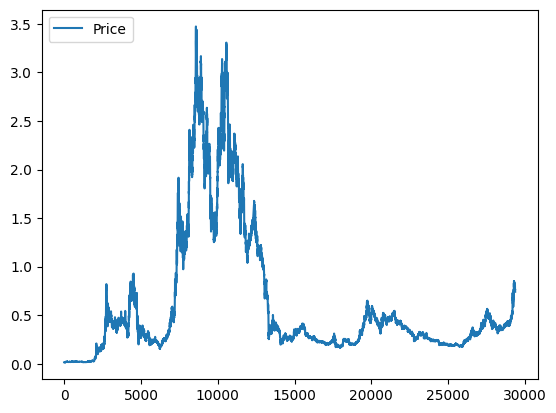

In [3]:
# Download dataset
ppo_config["env_config"]["dataset_name"] = 'dataset' 

SAVE_FOLDER = "data/{}".format(ppo_config["env_config"]["dataset_name"])

tech_array = np.load(os.path.join(SAVE_FOLDER, "metrics_outfile.npy"))
print("tech_array_shape:", tech_array.shape)
price_array = np.load(os.path.join(SAVE_FOLDER, "price_outfile.npy"))
print("price_array_shape:", price_array.shape)

plt.plot(price_array, label='Price')

plt.legend(loc='upper left')
plt.show()

In [4]:
# Rewrite config for backtesting
ppo_config["env_config"]["test_start"] = [26000, ]
ppo_config["env_config"]["test_end"] =  [29377 - 1, ]
ppo_config["env_config"]["episode_max_len"] = ppo_config["env_config"]["test_end"][0] - ppo_config["env_config"]["test_start"][0]

ppo_config["env_config"]["initial_capital"] = 1000
ppo_config["env_config"]["order_size"] = 50

ppo_config["num_gpus"] = 1 # 0 for CPU
ppo_config["num_rollout_workers"] = 1
ppo_config["num_envs_per_worker"] = 1

ppo_config["explore"] = False
ppo_config["env_config"]["regime"] = "backtesting"
ppo_config["env_config"]["record_stats"] = True
ppo_config["env_config"]["initial_random_allocated"] = 0

ppo_config["env_config"]["open_fee"] = 0.06e-2 # taker fee
ppo_config["env_config"]["close_fee"] = 0.06e-2 # taker fee

# ppo_config["model"]["lstm_use_prev_action"] = False
# ppo_config["model"]["lstm_use_prev_reward"] = False

env = LearningCryptoEnv(**ppo_config["env_config"])
agent = PPOTrainer(config=ppo_config)

2024-05-06 14:04:07,809	INFO algorithm_config.py:2899 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2024-05-06 14:04:07,848	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=899885) 2024-05-06 14:04:10,734	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=899885) 2024-05-06 14:04:10,734	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=899885) WARNI

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'obs_history_external_enc' can't be nonlocal (__autograph_generated_filepgo86ts3.py, line 35)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'obs_history_external_enc' can't be nonlocal (__autograph_generated_filepgo86ts3.py, line 35)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2024-05-06 14:04:17,798	WARNING deprecation.py:50 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
(RolloutWorker pid=901728) 2024-05-06 14:04:29,504	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=901728) 2024-05-06 14:04:29,505	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=901731) WARNING:tensorflow:AutoGraph could not transform <bound method Transformer.call of <models.transformer.Transformer object at 0x7f815c5c7f70>> and will run it as-is.
(RolloutWorker pid=901731) Please report this to the TensorFlow team. When filing the bug, set the verbos

MULTI MODEL TEST

In [7]:
# directory with checkpoins saved during training 
CHECKPOINTS_FOLDER = "./results/PPO/PPO_CryptoEnv_f57a8_00000_0_2024-05-03_20-45-41"

checkpoints_paths = []

for root, dirs, files in os.walk(CHECKPOINTS_FOLDER):
    for file in files:
        if "policy_state" in file:
            root_new = "/".join(root.split("/")[:-2]) 
            checkpoints_paths.append(root_new)
            
checkpoints_paths = sorted(checkpoints_paths)

print("checkpoints in folder: ", len(checkpoints_paths))

checkpoints in folder:  27


In [14]:
dictionary = {}

final_return = []
final_return_long = []
final_return_short = []

annual_volatility = []
sharpe_ratio = []
calmar_ratio = []
stability = []
max_drawdown = []
omega_ratio = []
sortino_ratio = []
tail_ratio = []
daily_value_at_risk = []

i = 0
for i, checkpoint_path in enumerate(checkpoints_paths): 
    print("index:", i, "/", len(checkpoints_paths))
    print("checkpoint_path:", checkpoint_path)

    agent.load_checkpoint(checkpoint_path)

    done = False
    account_equity = []
    account_balance = ppo_config["env_config"]["initial_capital"]
    total_reward = 0
    obs = env.reset()[0]

    while not done:
        action = agent.compute_single_action(observation=obs, prev_action=None, prev_reward=None)
        
        obs, reward, done, _, info = env.step(action)
        account_balance = info["equity"][-1]
        account_equity.append(account_balance)

        total_reward += reward
        
    final_return.append(account_equity[-1])
    final_return_long.append(np.sum(info["reward_realized_pnl_long"]) + info['unrealized_pnl_long'][-1])
    final_return_short.append(np.sum(info["reward_realized_pnl_short"]) + info['unrealized_pnl_short'][-1])

    perf_stats_all = backtest_stats(account_equity)
    
    annual_volatility.append(perf_stats_all.loc["Annual volatility"])
    sharpe_ratio.append(perf_stats_all.loc["Sharpe ratio"])
    calmar_ratio.append(perf_stats_all.loc["Calmar ratio"])
    stability.append(perf_stats_all.loc["Stability"])
    max_drawdown.append(perf_stats_all.loc["Max drawdown"])
    omega_ratio.append(perf_stats_all.loc["Omega ratio"])
    sortino_ratio.append(perf_stats_all.loc["Sortino ratio"])
    tail_ratio.append(perf_stats_all.loc["Tail ratio"])
    daily_value_at_risk.append(perf_stats_all.loc["Daily value at risk"])

    dictionary['checkpoint_path'] = checkpoints_paths
    dictionary['final_return'] = final_return
    dictionary['final_return_long'] = final_return_long
    dictionary['final_return_short'] = final_return_short
    dictionary['annual_volatility'] = annual_volatility
    dictionary['sharpe_ratio'] = sharpe_ratio
    dictionary['calmar_ratio'] = calmar_ratio
    dictionary['stability'] = stability
    dictionary['max_drawdown'] = max_drawdown
    dictionary['sortino_ratio'] = sortino_ratio
    dictionary['tail_ratio'] = tail_ratio
    dictionary['daily_value_at_risk'] = daily_value_at_risk

    json_object = json.dumps(dictionary, indent = 4) 

    # Save all statistics in json file every iteration
    with open(os.path.join(CHECKPOINTS_FOLDER, "statistics_checkpoints_0:{}.json".format(len(checkpoints_paths))), "w") as outfile:
        outfile.write(json_object)

    print("account_value:", np.round(account_equity[-1], 2))
    print("final_return_long:", np.round(final_return_long[-1], 2))
    print("final_return_short:", np.round(final_return_short[-1],2))
    print("max_drawdown:", np.round(max_drawdown[-1], 2))
    print("\n")

In [13]:
plot(final_return, "Return per checkpoint")
plot(max_drawdown, "Max drowdown per checkpoint")

In [10]:
# # Plot all evaluated metrics
# plot(np.array(annual_volatility), label='Annual Volatility')
# plot(np.array(sharpe_ratio), label='Sharpe Ratio')
# plot(np.array(calmar_ratio), label='Calmar Ratio')
# plot(np.array(stability), label='Stability')
# plot(np.array(omega_ratio), label='Omega Ratio')
# plot(np.array(sortino_ratio), label='Sortino Ratio')
# plot(np.array(tail_ratio), label='Tail Ratio')
# plot(np.array(daily_value_at_risk), label='Daily Value at Risk')

In [10]:
# open saved json with statistics
with open(os.path.join(CHECKPOINTS_FOLDER, "statistics_checkpoints_0:{}.json".format(len(checkpoints_paths)))) as user_file:
    file_contents = user_file.read()

parsed_json = json.loads(file_contents)

for i, final_return in enumerate(parsed_json['final_return']):
    print("i", i)
    print("checkpoint_path", parsed_json['checkpoint_path'][i])
    print('final_return', np.round(final_return, 2))
    print('final_return_long', np.round(parsed_json['final_return_long'][i], 2))
    print('final_return_short', np.round(parsed_json['final_return_short'][i], 2))

    print('max_drawdown', np.round(parsed_json['max_drawdown'][i], 2))

In [13]:
plot(parsed_json['final_return'], label="Return per checkpoint")
plot(parsed_json['max_drawdown'], label="Max drowdown per checkpoint")

SINGLE MODEL BACKTEST

In [5]:
# Rewrite config for backtesting
ppo_config["env_config"]["test_start"] = [26000, ]
ppo_config["env_config"]["test_end"] =  [29377 - 1, ]
ppo_config["env_config"]["episode_max_len"] = ppo_config["env_config"]["test_end"][0] - ppo_config["env_config"]["test_start"][0]

env = LearningCryptoEnv(**ppo_config["env_config"])

# Checkpoint path to evaluate
checkpoint_path = "./results/PPO/PPO_CryptoEnv_1a171_00000_0_2024-05-02_11-51-01/checkpoint_000204"

# agent.load_checkpoint(checkpoint_path)
agent.restore(checkpoint_path)

done = False
account_equity = []
total_reward = 0
account_balance = ppo_config["env_config"]["initial_capital"]

obs = env.reset()[0]

start = time.time()

while not done:
    action = agent.compute_single_action(obs, prev_action=None, prev_reward=None, explore=False)
    # print(f"Action: {action}")

    obs, reward, done, _, info = env.step(action)
    # print(f"Reward: {reward}")

    total_reward += reward
    # print(f"Cumulative reward: {total_reward}")
        
    account_balance = info["equity"][-1]
    account_equity.append(account_balance)
    
end = time.time()
print("Duration:", np.round(end - start, 2), "sec")

2024-05-06 14:04:50,865	WARNING algorithm_config.py:596 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
2024-05-06 14:04:52,416	INFO trainable.py:791 -- Restored on 192.168.0.151 from checkpoint: results/PPO/PPO_CryptoEnv_1a171_00000_0_2024-05-02_11-51-01/checkpoint_000204
2024-05-06 14:04:52,417	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 204, '_timesteps_total': None, '_time_total': 26980.20886349678, '_episodes_total': 12240}


Duration: 16.42 sec


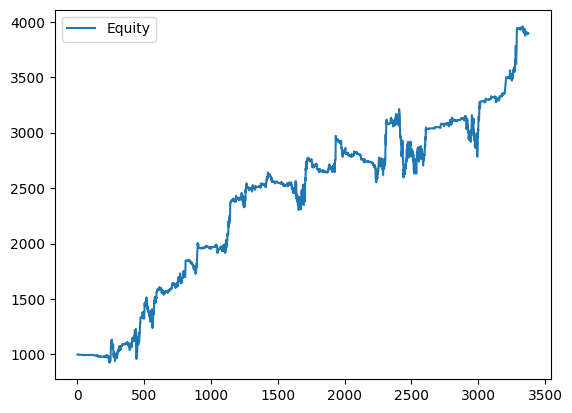

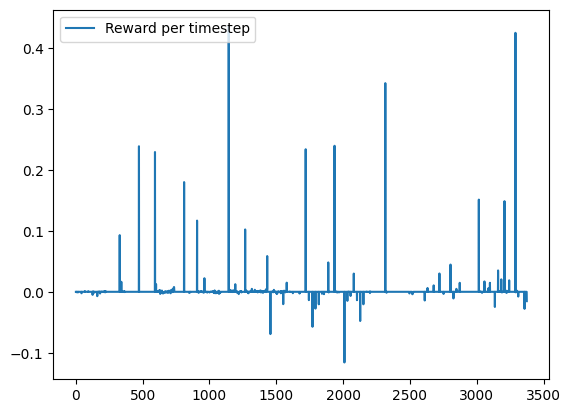

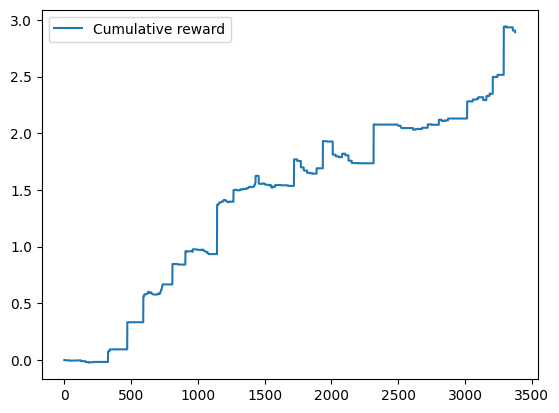

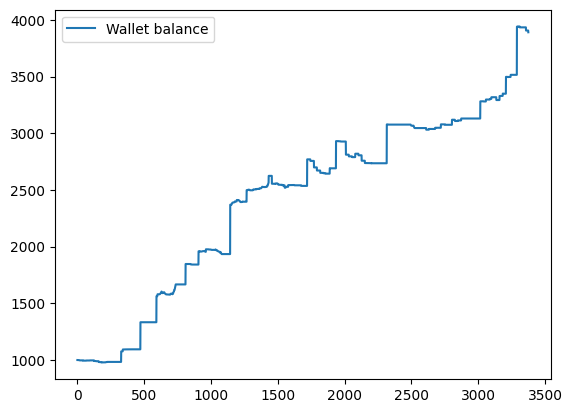

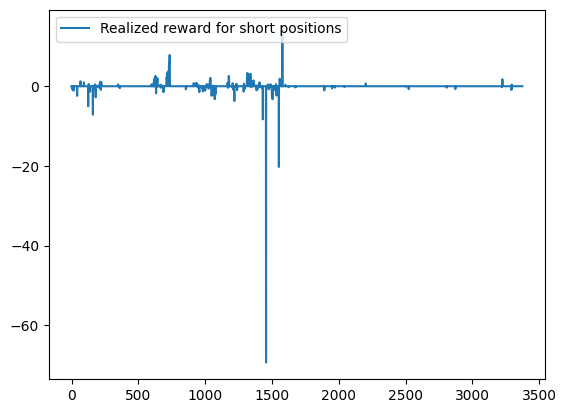

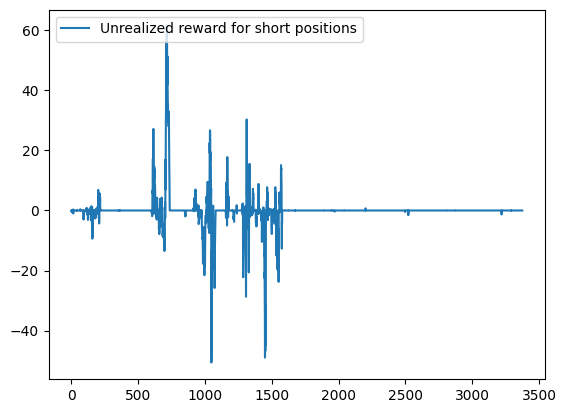

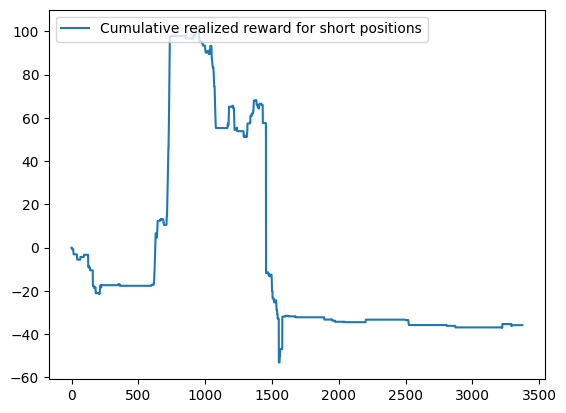

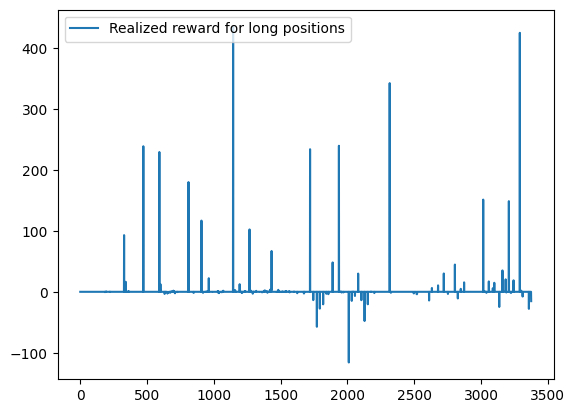

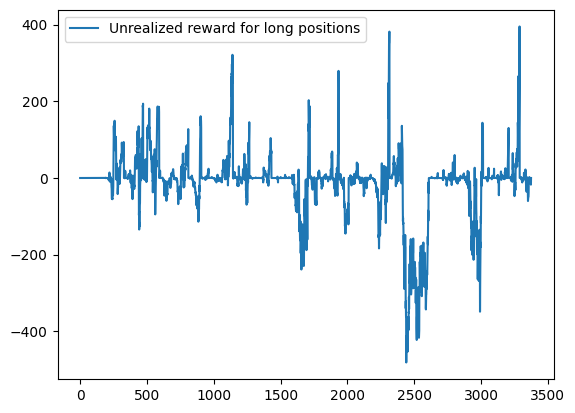

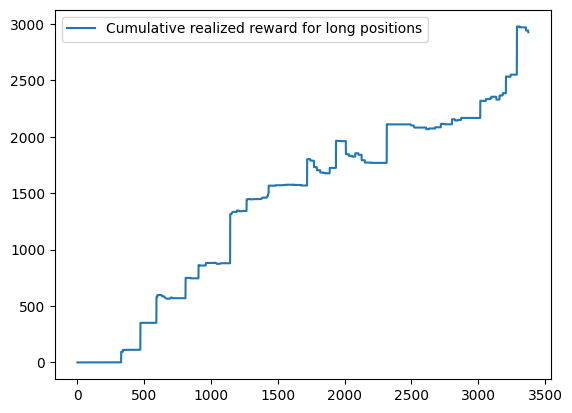

In [106]:
plot(info["equity"], "Equity")
plot(info["reward"], "Reward per timestep")
plot(np.cumsum(info["reward"]), "Cumulative reward")
plot(info["wallet_balance"], "Wallet balance")
plot(info['reward_realized_pnl_short'], "Realized PnL for short positions")
plot(info['unrealized_pnl_short'], "Unrealized PnL for short positions")
plot(np.cumsum(info['reward_realized_pnl_short']), "Cumulative realized PnL for short positions")
plot(info['reward_realized_pnl_long'], "Realized PnL for long positions")
plot(info['unrealized_pnl_long'], "Unrealized PnL for long positions")
plot(np.cumsum(info['reward_realized_pnl_long']), "Cumulative realized PnL for long positions")


In [107]:
print("Profit longs: ", np.round(np.sum(info["reward_realized_pnl_long"]) + info['unrealized_pnl_long'][-1], 2), "$")
print("Profit shorts: ", np.round(np.sum(info["reward_realized_pnl_short"]) + info['unrealized_pnl_short'][-1], 2), "$")

Profit longs:  2927.38 $
Profit shorts:  -35.85 $


In [108]:
action_0 = 0
action_1 = 0
action_2 = 0
action_3 = 0

for action in info["action"]:
    action_0 += list([action]).count(0)
    action_1 += list([action]).count(1)    
    action_2 += list([action]).count(2)
    action_3 += list([action]).count(3)

print("actions do nothing:", action_0)
print("actions buy:", action_1)
print("actions sell:", action_2)
print("actions close entire position:", action_3)

actions do nothing: 549
actions buy: 2014
actions sell: 408
actions close entire position: 405


SINGLE MODEL SLIDING WINDOW BACKTEST

In [112]:
# Checkpoint and config from SINGLE MODEL BACKTEST section are used
episode_start_shift = 168
episode_length = 168 * 2
start_index = 26000
end_index = 29377 - 1

account_equity = []

for test_start in range(start_index, end_index - 1, episode_start_shift):
    ppo_config["env_config"]["test_start"] = [test_start, ]
    ppo_config["env_config"]["test_end"] =  [min(test_start + episode_length, end_index) - 1, ]
    ppo_config["env_config"]["episode_max_len"] = ppo_config["env_config"]["test_end"][0] - ppo_config["env_config"]["test_start"][0]

    env = LearningCryptoEnv(**ppo_config["env_config"])

    done = False
    account_balance = ppo_config["env_config"]["initial_capital"]
    total_reward = 0
    obs = env.reset()[0]

    start = time.time()

    while not done:
        action = agent.compute_single_action(obs, prev_action=None, prev_reward=None, explore=False)
        # print(f"Action: {action}")

        obs, reward, done, _, info = env.step(action)
        # print(f"Reward: {reward}")

        total_reward += reward
        # print(f"Cumulative reward: {total_reward}")
            
        account_balance = info["equity"][-1]
    
    account_equity.append(account_balance)
        
    end = time.time()
    print("Duration:", np.round(end - start, 2), "sec;", "Equity: ", np.round(account_balance, 2), "$")

In [113]:
plot(account_equity, "Equity per window")
print("cumulative pnl over all windows: ", np.round(np.sum(account_equity) - ppo_config["env_config"]["initial_capital"] * len(account_equity), 2), "$")

PLOT TRADES

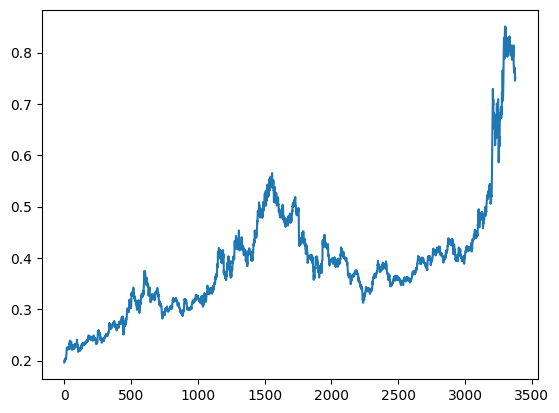

In [6]:
# The following segment of code is used to display trades from the most recent run.
# In the event that visualization of the entire validation dataset is required (as opposed to just the last sliding window in the SINGLE MODEL SLIDING WINDOW BACKTEST section),
# you should first execute the SINGLE MODEL BACKTEST section before moving on to the PLOT TRADES section.

price_array_render = np.load(os.path.join(SAVE_FOLDER, "price_outfile.npy"))[ppo_config["env_config"]["test_start"][0]:ppo_config["env_config"]["test_end"][0]]
plt.plot(price_array_render)

In [7]:
plot_trades("short", info, price_array_render[:,0], annotate_markers=True, save_plot=True) # side_indicator must be "long" or "short"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
